In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# 1. Import Dataset

In [2]:
# from poc_data import PocDataset

# poc_raw_dataset = PocDataset(num_cases=2**10)
# data_loader = torch.utils.data.DataLoader(poc_raw_dataset,batch_size=128)
# batch, event, time_to_event, _latent_variable = next(iter(data_loader))

# print(batch.shape)
# print(event.shape)
# print(time_to_event.shape)
# print(_latent_variable.shape)

### Data Exploration

In [3]:
#Take a look at the longitudional data

# plt.plot(np.array(batch[0][:int(time_to_event[0]),1]), batch[0][:int(time_to_event[0]),2])
# plt.plot(np.array(batch[1][:int(time_to_event[1]),1]), batch[1][:int(time_to_event[1]),2])
# plt.plot(np.array(batch[2][:int(time_to_event[2]),1]), batch[2][:int(time_to_event[2]),2])
# plt.plot(np.array(batch[3][:int(time_to_event[3]),1]), batch[3][:int(time_to_event[3]),2])
# plt.plot(np.array(batch[4][:int(time_to_event[4]),1]), batch[4][:int(time_to_event[4]),2])

# print(event[:5])
# print(time_to_event[:5])
# print(_latent_variable[:5])

# 2. Hyperparameters

# 3. Defining The Model

# 4. Training the model

tensor([[ 0.0000e+00,  1.4101e+01,  8.9990e-01],
        [ 0.0000e+00,  1.4642e+01,  7.8809e-01],
        [ 0.0000e+00,  1.5184e+01,  4.5066e-01],
        [ 0.0000e+00,  1.5725e+01, -1.5789e-02],
        [ 0.0000e+00,  1.6267e+01, -4.7772e-01],
        [ 0.0000e+00,  1.6809e+01, -8.0288e-01],
        [ 0.0000e+00,  1.7350e+01, -8.9819e-01],
        [ 0.0000e+00,  1.7892e+01, -7.3636e-01],
        [ 0.0000e+00,  1.8434e+01, -3.6372e-01],
        [ 0.0000e+00,  1.8975e+01,  1.1304e-01]])


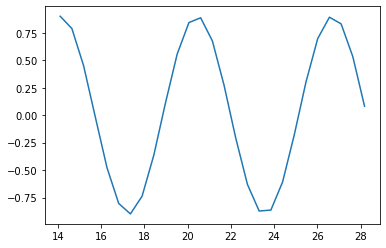

In [4]:
from poc_data import PocDataset

test_poc_raw_dataset = PocDataset(num_cases=1)
test_data_loader = torch.utils.data.DataLoader(test_poc_raw_dataset,batch_size=1)
test_batch, test_event, test_time_to_event, _latent_variable = next(iter(test_data_loader))

plt.plot(np.array(test_batch[0][:int(test_time_to_event[0]),1]), test_batch[0][:int(test_time_to_event[0]),2])
print(test_batch[0,:10])

In [5]:
from torch.nn import MSELoss
from tqdm import trange, tqdm

from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from dynamicDeepHit import EncoderRNN, AttnDecoderRNN

#poc_raw_dataset = PocDataset(num_cases=2**5)
data_loader = torch.utils.data.DataLoader(test_poc_raw_dataset,batch_size=1)

NUM_EPOCHS = 5000
LEARNING_RATE = 0.0001
input_size = 3
output_size = input_size
hidden_size = 256
MAX_LENGTH = 30

# initialize model
encoder = EncoderRNN(input_size, hidden_size)
decoder = AttnDecoderRNN(hidden_size, output_size, MAX_LENGTH)

# intialize optimizer
optimizer_encoder = Adam(encoder.parameters(), lr=LEARNING_RATE)
optimizer_decoder = Adam(decoder.parameters(), lr=LEARNING_RATE)
 
# initialize loss
mse_loss = MSELoss()
writer = SummaryWriter()

tensor([[ 0.0384, -0.0768,  0.0402],
        [ 0.0421, -0.0671,  0.0573],
        [ 0.0408, -0.0625,  0.0696],
        [ 0.0406, -0.0614,  0.0780],
        [ 0.0413, -0.0605,  0.0836],
        [ 0.0420, -0.0600,  0.0879],
        [ 0.0425, -0.0594,  0.0913],
        [ 0.0426, -0.0589,  0.0938],
        [ 0.0424, -0.0584,  0.0958],
        [ 0.0420, -0.0576,  0.0972]], grad_fn=<SliceBackward>)


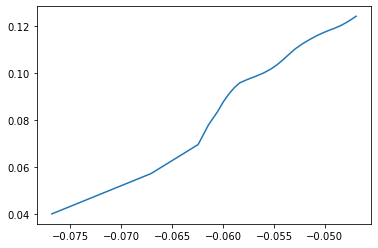

In [6]:
test_encoder_hidden_vector = torch.zeros(MAX_LENGTH, encoder.hidden_size)
test_encoder_output_vector = torch.zeros(MAX_LENGTH, encoder.input_size)
test_encoder_hidden = encoder.initHidden()

for ei in range(test_batch.size(1)):
        test_encoder_input = test_batch[0][ei].view(1,1,-1)
        test_encoder_output, test_encoder_hidden = encoder(test_encoder_input, test_encoder_hidden)
        test_encoder_output_vector[ei] = test_encoder_output

plt.plot(np.array(test_encoder_output_vector.detach()[:int(test_time_to_event[0]),1]), test_encoder_output_vector.detach()[:int(test_time_to_event[0]),2])
print(test_encoder_output_vector[:10])

In [7]:
# start training
for epoch in trange(NUM_EPOCHS):

  epoch_loss = 0

  for i, data in enumerate(data_loader):

    batch, event, time_to_event, _latent_variable = data

    optimizer_encoder.zero_grad()
    optimizer_decoder.zero_grad()

    encoder_hidden_vector = torch.zeros(MAX_LENGTH, encoder.hidden_size)
    encoder_output_vector = torch.zeros(MAX_LENGTH, encoder.input_size)
    encoder_hidden = encoder.initHidden()

    for ei in range(batch.size(1)):
        encoder_input = batch[0][ei].view(1,1,-1)
        encoder_output, encoder_hidden = encoder(encoder_input, encoder_hidden)
        #encoder_hidden_vector[ei] = self.encoder_hidden[0,0]
        encoder_output_vector[ei] = encoder_output

    loss3 = mse_loss(encoder_output_vector[:-1], batch.detach().squeeze(0)[1:])

    epoch_loss += loss3

  epoch_loss.backward()
  optimizer_encoder.step()
  
  writer.add_scalar('Loss/Train', epoch_loss.item(), epoch)
print("av_epoch_train_loss=", epoch_loss.item()/len(data_loader))

100%|██████████| 5000/5000 [03:17<00:00, 25.29it/s]

av_epoch_train_loss= 0.0005247925291769207


tensor([[ 0.0000e+00,  1.4101e+01,  8.9990e-01],
        [ 0.0000e+00,  1.4642e+01,  7.8809e-01],
        [ 0.0000e+00,  1.5184e+01,  4.5066e-01],
        [ 0.0000e+00,  1.5725e+01, -1.5789e-02],
        [ 0.0000e+00,  1.6267e+01, -4.7772e-01],
        [ 0.0000e+00,  1.6809e+01, -8.0288e-01],
        [ 0.0000e+00,  1.7350e+01, -8.9819e-01],
        [ 0.0000e+00,  1.7892e+01, -7.3636e-01],
        [ 0.0000e+00,  1.8434e+01, -3.6372e-01],
        [ 0.0000e+00,  1.8975e+01,  1.1304e-01]])


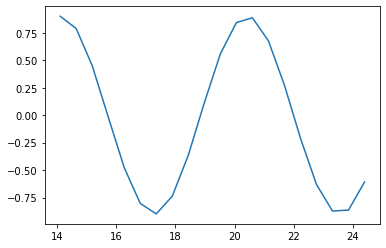

In [12]:
plt.plot(np.array(test_batch[0][:20,1]), test_batch[0][:20,2])
print(test_batch[0,:10])

tensor([[-3.0145e-03,  1.4645e+01,  7.8304e-01],
        [ 7.2029e-03,  1.5184e+01,  4.5456e-01],
        [ 3.8912e-03,  1.5726e+01, -1.3514e-02],
        [-6.6382e-03,  1.6268e+01, -4.7973e-01],
        [-3.8615e-03,  1.6807e+01, -7.9712e-01],
        [-1.1142e-03,  1.7358e+01, -9.1098e-01],
        [ 1.9309e-03,  1.7885e+01, -7.2937e-01],
        [ 4.6687e-03,  1.8433e+01, -3.5713e-01],
        [ 5.5620e-03,  1.8982e+01,  1.1313e-01],
        [-2.8219e-03,  1.9514e+01,  5.5138e-01],
        [-3.6660e-03,  2.0057e+01,  8.4454e-01],
        [-4.6560e-03,  2.0602e+01,  8.8339e-01],
        [-6.7159e-04,  2.1144e+01,  6.7453e-01],
        [ 7.8467e-03,  2.1683e+01,  2.7532e-01],
        [ 9.7652e-03,  2.2225e+01, -2.0556e-01],
        [ 1.2982e-04,  2.2769e+01, -6.3983e-01],
        [-9.6280e-03,  2.3306e+01, -8.6799e-01],
        [-3.8628e-03,  2.3845e+01, -8.4959e-01],
        [ 4.3002e-04,  2.4379e+01, -5.8082e-01],
        [ 3.9244e-03,  2.4927e+01, -1.9629e-01]])


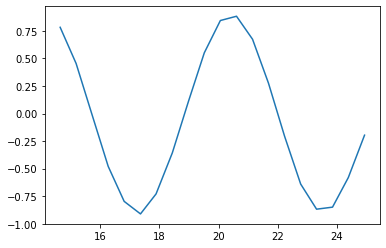

In [11]:
test_encoder_hidden_vector = torch.zeros(MAX_LENGTH, encoder.hidden_size)
test_encoder_output_vector = torch.zeros(MAX_LENGTH, encoder.input_size)
test_encoder_hidden = encoder.initHidden()

for ei in range(batch.size(1)):
        test_encoder_input = test_batch[0][ei].view(1,1,-1)
        test_encoder_output, test_encoder_hidden = encoder(test_encoder_input, test_encoder_hidden)
        test_encoder_output_vector[ei] = test_encoder_output

test_encoder_output_vector = test_encoder_output_vector.unsqueeze(0).detach()
plt.plot(np.array(test_encoder_output_vector[0][:20,1]), test_encoder_output_vector[0][:20,2])
print(test_encoder_output_vector[0,:20])